In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Collecte des données 

Pour analyser, l'impact des taux d'intérêts dans chaque secteur de l'économie, nous allons utiliser des ETFs réplicants chacun des secteurs de l'économie américaine : 

Pour obtenir les tickers des ETFs (Exchange Traded Funds) qui représentent chacun de ces secteurs de l'économie américaine, on peut généralement se référer à des ETFs populaires qui sont largement utilisés pour suivre la performance de ces secteurs spécifiques.

1. **Finance** - Financial Select Sector SPDR Fund (`XLF`)
2. **Medical** - Health Care Select Sector SPDR Fund (`XLV`)
3. **Computer and Technology** - Technology Select Sector SPDR Fund (`XLK`)
4. **Oils/Energy** - Energy Select Sector SPDR Fund (`XLE`)
5. **Retail/Wholesale** - SPDR S&P Retail ETF (`XRT`)
6. **Consumer Staples** - Consumer Staples Select Sector SPDR Fund (`XLP`)
7. **Basic Materials** - Materials Select Sector SPDR Fund (`XLB`)
8. **Industrial Products** - Industrial Select Sector SPDR Fund (`XLI`)9
9. **Utilities** - Utilities Select Sector SPDR Fund (`XLU`)
10. **Consumer Discretionary** - Consumer Discretionary Select Sector SPDR Fund (`XLY`)
11. **Transportation** - iShares Transportation Average ETF (`XTN`)
13. **Aerospace** - iShares U.S. Aerospace & Defense ETF (`XAR`)

Ces ETFs représentent une façon courante d'investir dans ces secteurs sans avoir à sélectionner des actions individuelles. Pour chaque secteur non couvert spécifiquement par un ETF, comme "Business Services" ou "Multi-Sector Conglomerates", vous pourriez envisager d'utiliser des indices plus larges ou de sélectionner des entreprises individuelles qui représentent bien ces secteurs. Pour les données les plus précises et les mises à jour, vous devriez vérifier chaque fonds sur une plateforme financière comme Yahoo Finance ou Bloomberg pour vous assurer que les tickers sont toujours actifs et représentatifs du secteur voulu.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2020-01-02 to 2024-05-03
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Finance                  1092 non-null   float64
 1   Medical                  1092 non-null   float64
 2   Computer and Technology  1092 non-null   float64
 3   Oils/Energy              1092 non-null   float64
 4   Retail/Wholesale         1092 non-null   float64
 5   Consumer Staples         1092 non-null   float64
 6   Basic Materials          1092 non-null   float64
 7   Industrial Products      1092 non-null   float64
 8   Utilities                1092 non-null   float64
 9   Consumer Discretionary   1092 non-null   float64
 10  Transportation           1092 non-null   float64
 11  Aerospace                1092 non-null   float64
dtypes: float64(12)
memory usage: 110.9 KB
None
                  FEDFUNDS
observation_date          
2020-01-01       

<Figure size 3000x1700 with 0 Axes>

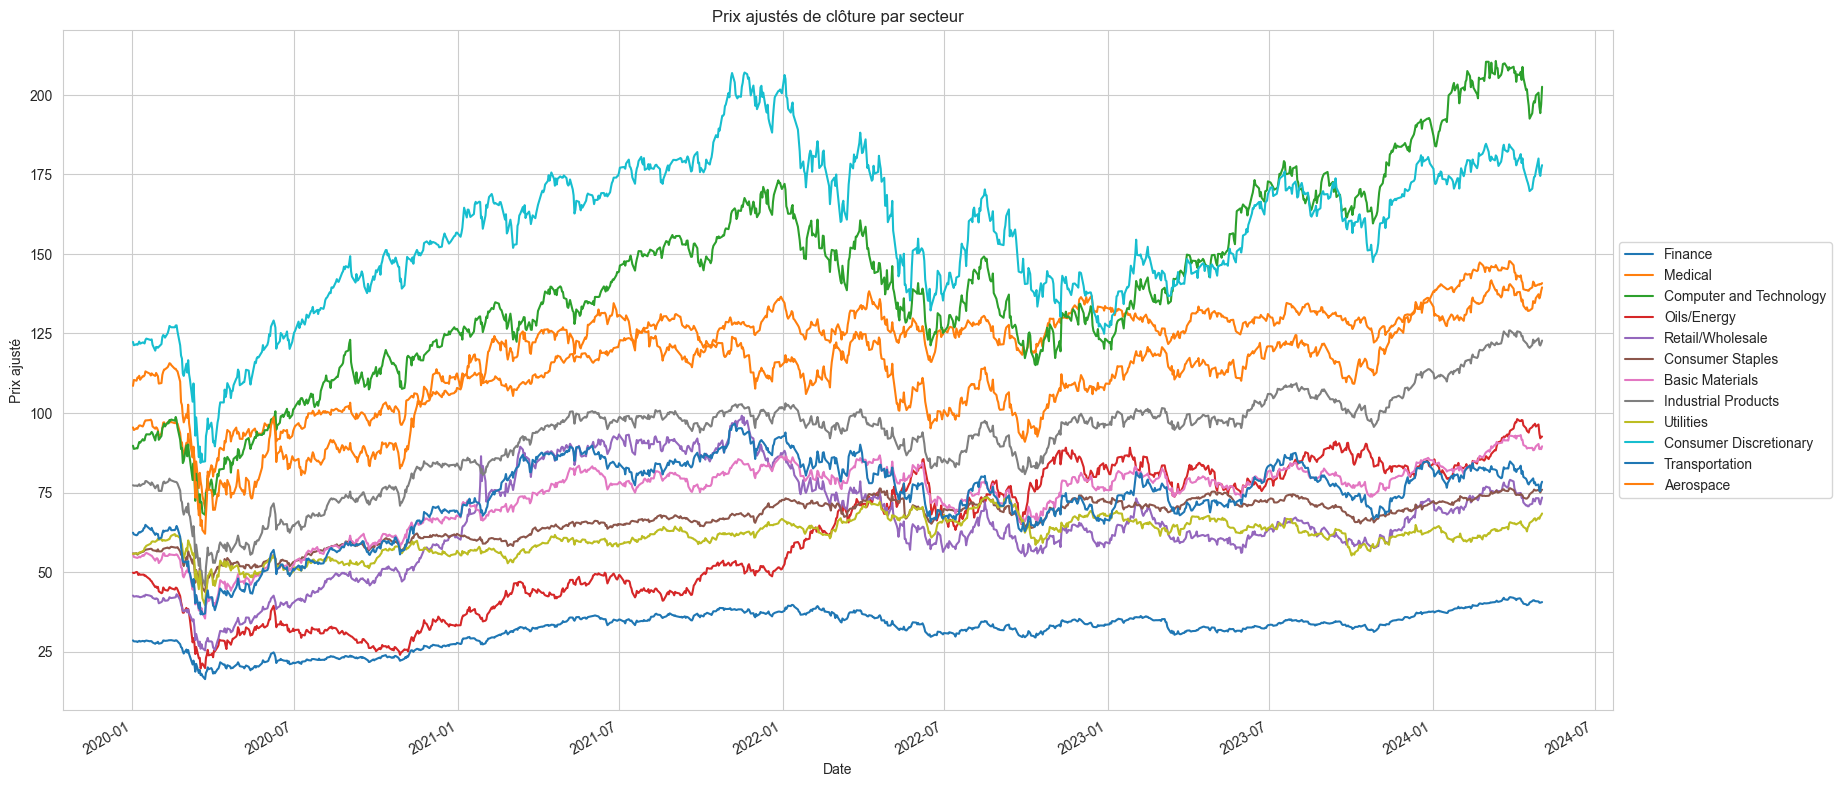

In [2]:
# Définir les tickers des ETF pour chaque secteur
sector_tickers = {
    "Finance": "XLF",
    "Medical": "XLV",
    "Computer and Technology": "XLK",
    "Oils/Energy": "XLE",
    "Retail/Wholesale": "XRT",
    "Consumer Staples": "XLP",
    "Basic Materials": "XLB",
    "Industrial Products": "XLI",
    "Utilities": "XLU",
    "Consumer Discretionary": "XLY",
    "Transportation": "XTN",
    "Aerospace": "XAR"
}

# Télécharger les données pour chaque ticker
data = {}
for sector, ticker in sector_tickers.items():
    try:
        # Téléchargement des données de prix ajustés de clôture
        data[sector] = yf.download(ticker, start="2020-01-01", end="2024-05-05")['Adj Close']
    except Exception as e:
        print(f"Échec du téléchargement pour {ticker}: {e}")

# Conversion en DataFrame
sector_data = pd.DataFrame(data)

# Vérification des données manquantes
print(sector_data.info())

# Téléchargement des données des taux d'intérêt de la FED
try:
    fed_rate = pd.read_excel('FEDFUNDS.xls')
    fed_rate['observation_date'] = pd.to_datetime(fed_rate['observation_date'])
    fed_rate.set_index('observation_date', inplace=True)
    fed_rate_selected = fed_rate.loc['2020-01-01':'2024-04-01']
except Exception as e:
    print(f"Échec du chargement des taux de la FED: {e}")

# Afficher les données de taux d'intérêt
print(fed_rate_selected.head())

# Graphiques
plt.figure(figsize=(30, 17))
ax = sector_data.plot(title="Prix ajustés de clôture par secteur", figsize=(20, 10))
plt.ylabel("Prix ajusté")

# Positionner la légende à l'extérieur du graphique
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Analyse quantitative

Pour utiliser les données de rendements mensuels des secteurs et évaluer l'impact des taux de la FED, nous allons d'abord calculer ces rendements et ensuite les aligner avec les taux d'intérêt pour mener des analyses de régression

### Explications:

1. **Rendements Mensuels**: Calcul des rendements mensuels des secteurs à partir des données journalières. Cela standardise la périodicité pour l'analyse avec les taux de la FED.
2. **Alignement des Données**: Concaténation des rendements des secteurs avec les taux de la FED mensualisés, puis élimination des lignes avec des données manquantes.
3. **Régression Linéaire**: Utilisation de la régression OLS pour déterminer l'impact des taux de la FED sur les rendements sectoriels.
4. **Tests de Granger**: Évaluation de la causalité potentielle des taux de la FED sur les rendements sectoriels.
5. **Modèles GARCH**: Analyse de la volatilité des rendements sectoriels pour examiner comment la volatilité réagit aux changements dans les taux de la FED.


In [3]:
# Calcul des variations des taux Fed Funds pour rendre les données stationnaires
fed_rate_diff = fed_rate_selected.pct_change().dropna()

# Application du test ADF
result = adfuller(fed_rate_diff)

# Impression des résultats
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interprétation du résultat basée sur la statistique ADF et la p-value
if result[1] < 0.05:
    print("Les rendements de la Fed sont stationnaires.")
else:
    print("Les rendements de la Fed ne sont pas stationnaires.")


ADF Statistic: -3.2390674297088853
p-value: 0.017831785834974398
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Les rendements de la Fed sont stationnaires.


In [4]:
# Calcul de rendements mensuels pour les secteurs
monthly_returns = sector_data.resample('MS').ffill().pct_change()
# Alignement des données de rendements avec les taux
aligned_data = pd.concat([monthly_returns,fed_rate_diff], axis=1).dropna()

for sector in monthly_returns.columns:
    # Application du test ADF
    result = adfuller(aligned_data[sector])
    # Impression des résultats
    print('ADF Statistic '+sector+': ', result[0])
    print('p-value '+sector+': ', result[1])
    print('Critical Values '+sector+': ')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # Interprétation du résultat basée sur la statistique ADF et la p-value
    if result[1] < 0.05:
        print("Les rendements du secteur "+sector+ " sont stationnaires.")
    else:
        print("Les rendements du secteur "+sector+ " ne sont pas stationnaires.")

ADF Statistic Finance:  -3.673383076621354
p-value Finance:  0.004503509279760031
Critical Values Finance: 
	1%: -3.578
	5%: -2.925
	10%: -2.601
Les rendements du secteur Finance sont stationnaires.
ADF Statistic Medical:  -8.282901580211439
p-value Medical:  4.46984704543412e-13
Critical Values Medical: 
	1%: -3.571
	5%: -2.923
	10%: -2.599
Les rendements du secteur Medical sont stationnaires.
ADF Statistic Computer and Technology:  -7.770239403402775
p-value Computer and Technology:  8.961354557341453e-12
Critical Values Computer and Technology: 
	1%: -3.571
	5%: -2.923
	10%: -2.599
Les rendements du secteur Computer and Technology sont stationnaires.
ADF Statistic Oils/Energy:  -7.62363820223593
p-value Oils/Energy:  2.0964114229309805e-11
Critical Values Oils/Energy: 
	1%: -3.571
	5%: -2.923
	10%: -2.599
Les rendements du secteur Oils/Energy sont stationnaires.
ADF Statistic Retail/Wholesale:  -7.162331038163569
p-value Retail/Wholesale:  2.94604752312814e-10
Critical Values Retail

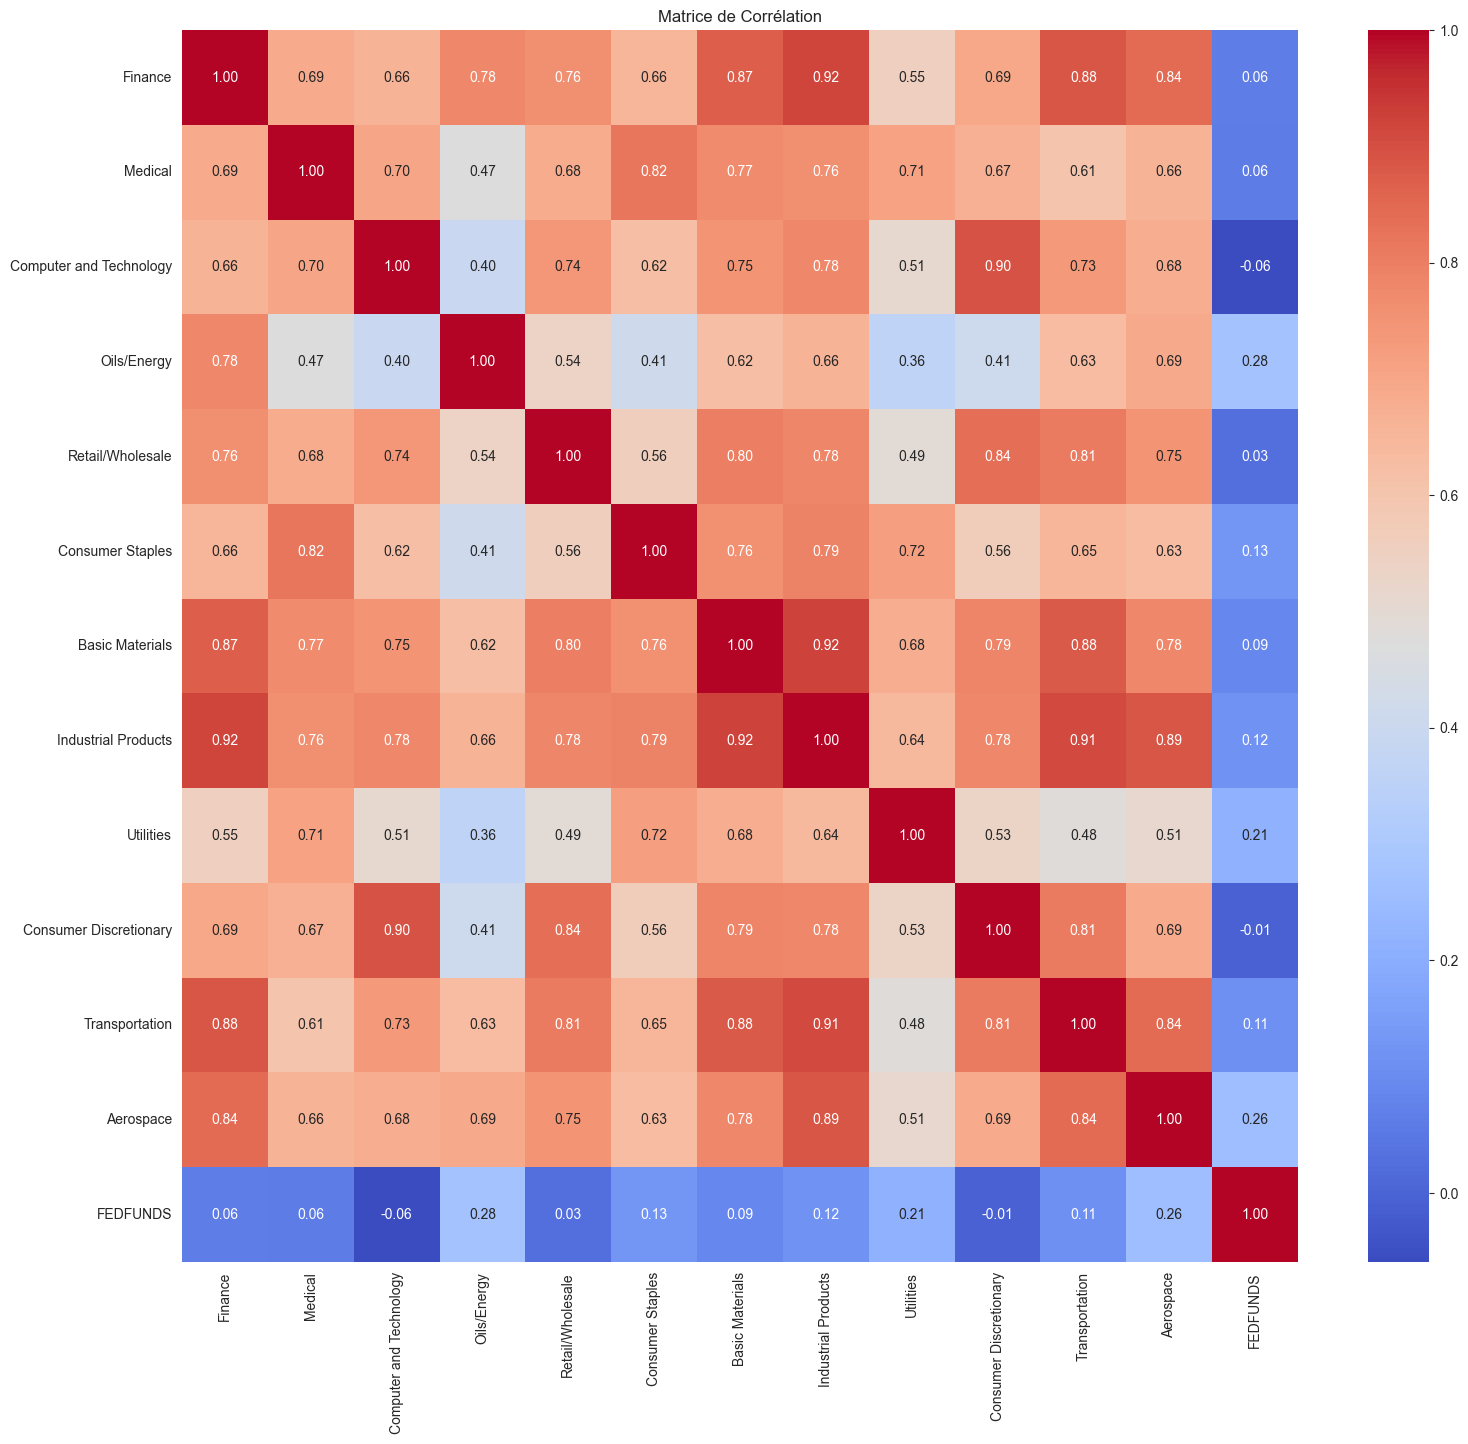

In [5]:
# Calcul de la matrice de corrélation
matriceCorrelation = np.corrcoef(aligned_data, rowvar=False)

# Ajustement de la taille de la figure
plt.figure(figsize=(18, 16))

# Création du heatmap avec seaborn
sns.heatmap(matriceCorrelation, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=aligned_data.columns, yticklabels=aligned_data.columns)

# Ajout d'un titre
plt.title('Matrice de Corrélation')

# Affichage de la figure
plt.show()

In [6]:
# Régression linéaire
X = sm.add_constant(aligned_data['FEDFUNDS'])  # Ajouter une constante à l'ensemble de données
results = {}
for sector in monthly_returns.columns:#sector_tickers.values():
    model = sm.OLS(aligned_data[sector], X,mising='drop').fit()
    results[sector] = model.summary()

# Afficher les résumés de régression
for sector, result in results.items():
    print(f"Résultats de régression pour {sector}:\n{result}\n\n")

Résultats de régression pour Finance:
                            OLS Regression Results                            
Dep. Variable:                Finance   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1856
Date:                Thu, 20 Jun 2024   Prob (F-statistic):              0.669
Time:                        23:17:08   Log-Likelihood:                 59.714
No. Observations:                  50   AIC:                            -115.4
Df Residuals:                      48   BIC:                            -111.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
/Users/jihanesabri/Documents/M2/Mac

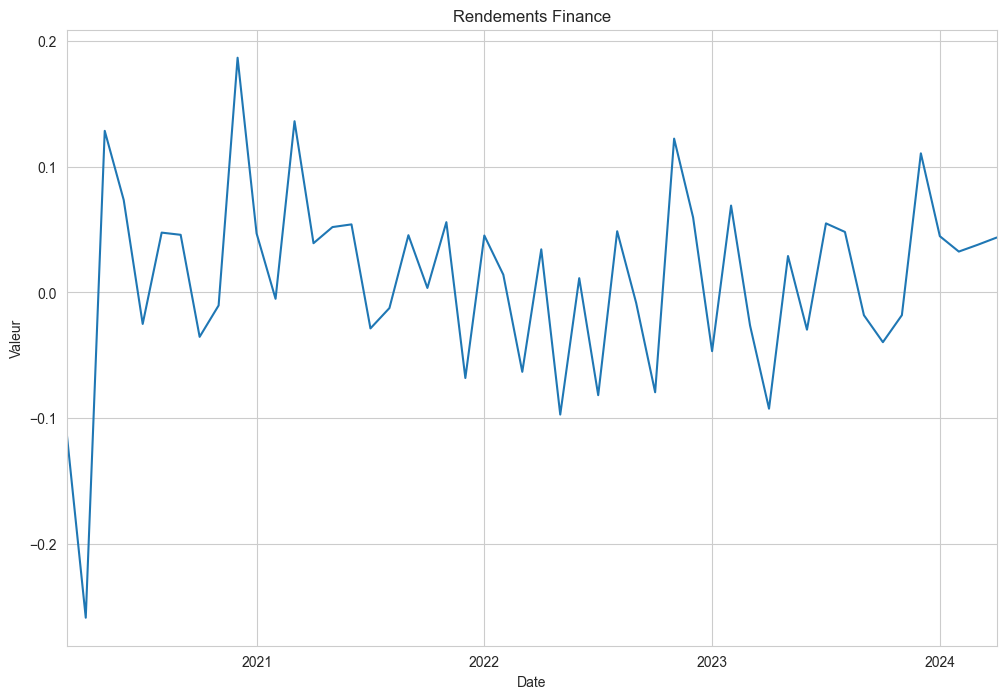

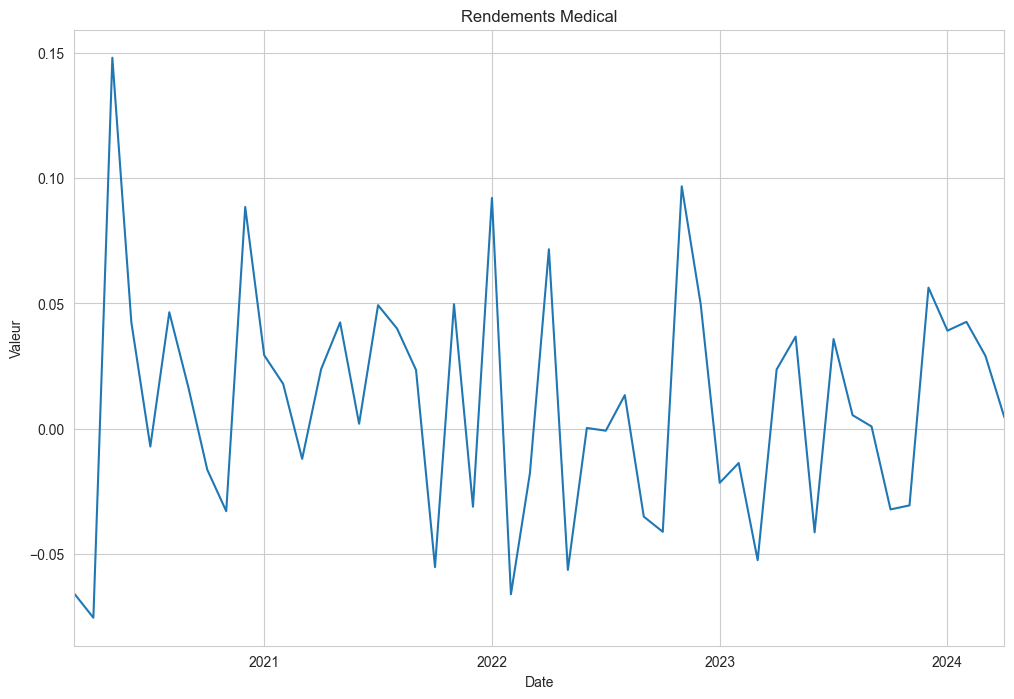

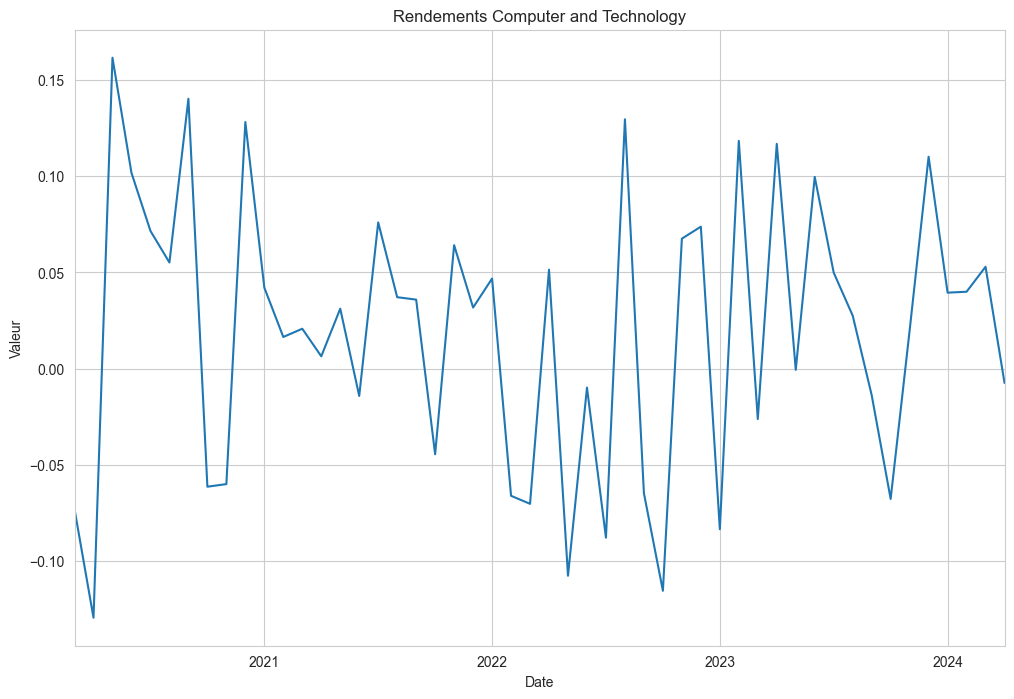

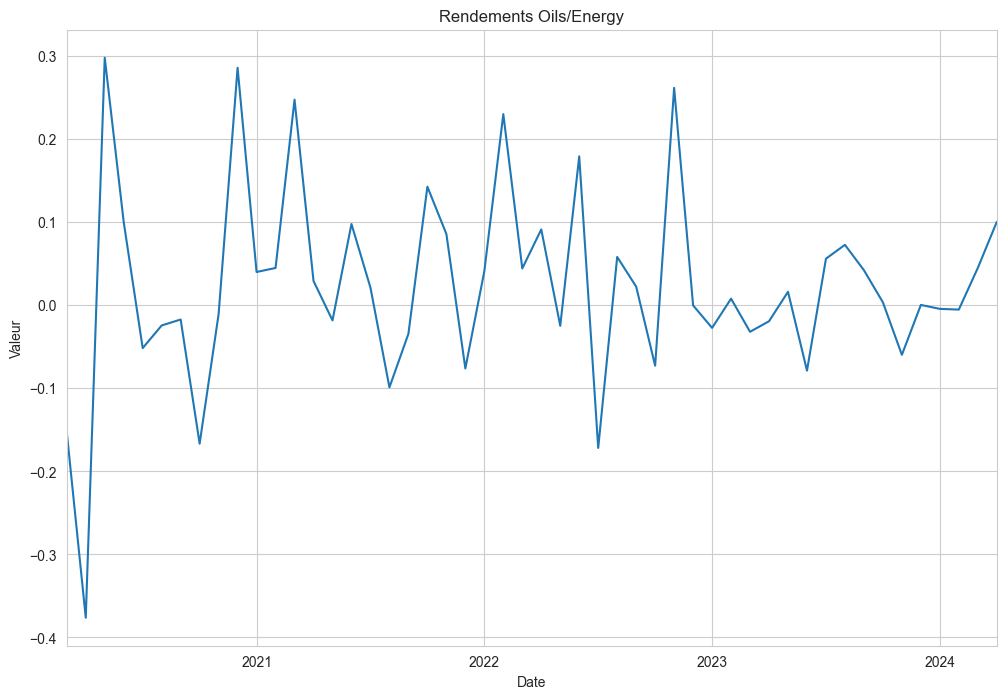

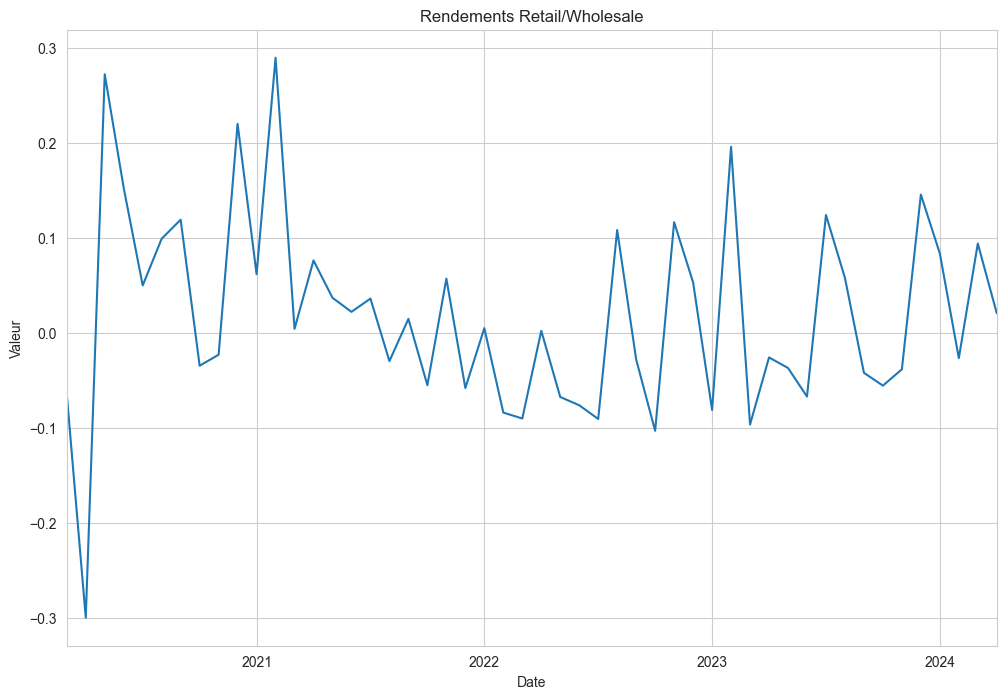

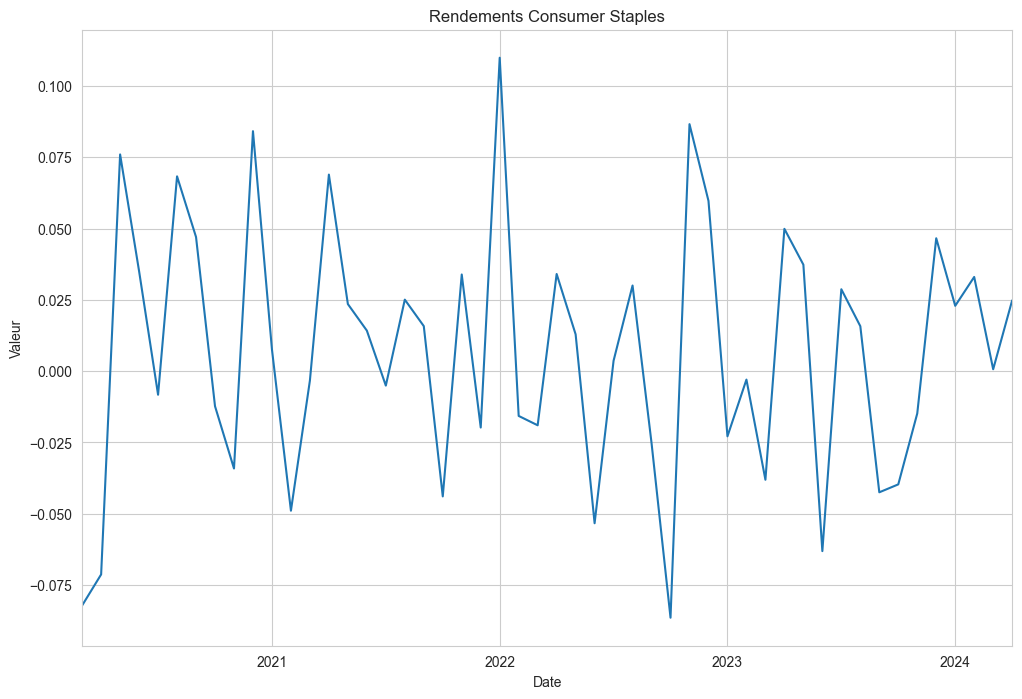

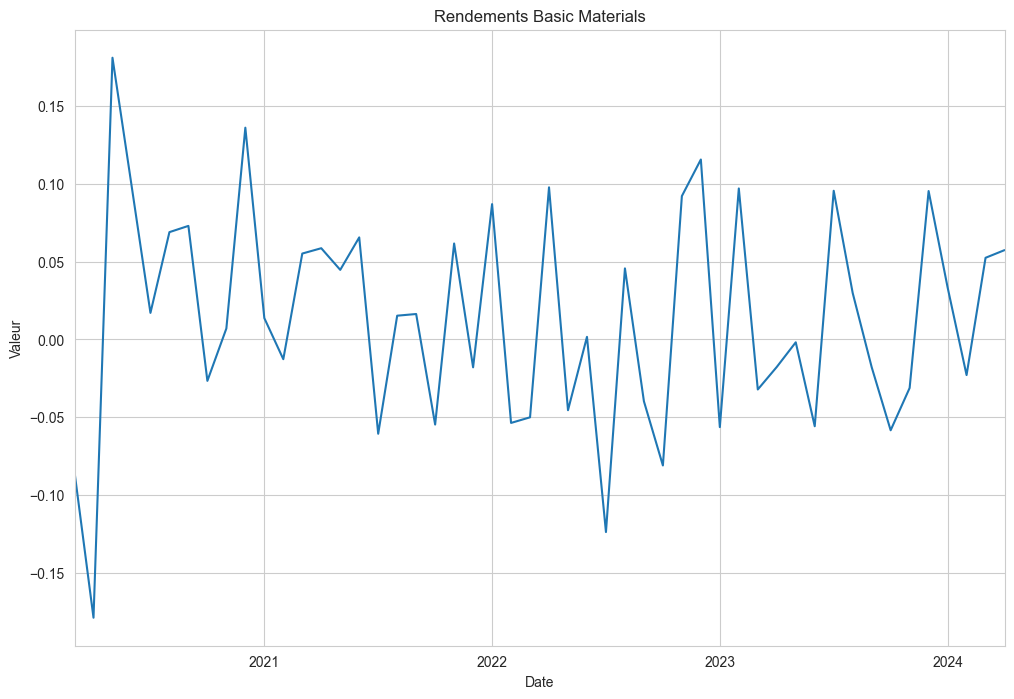

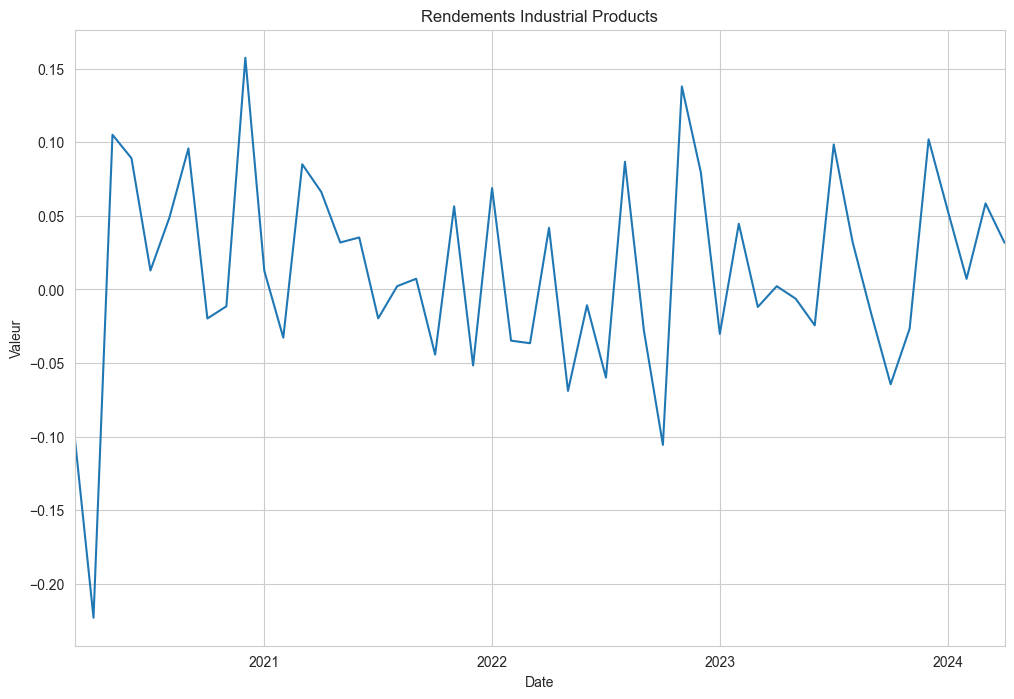

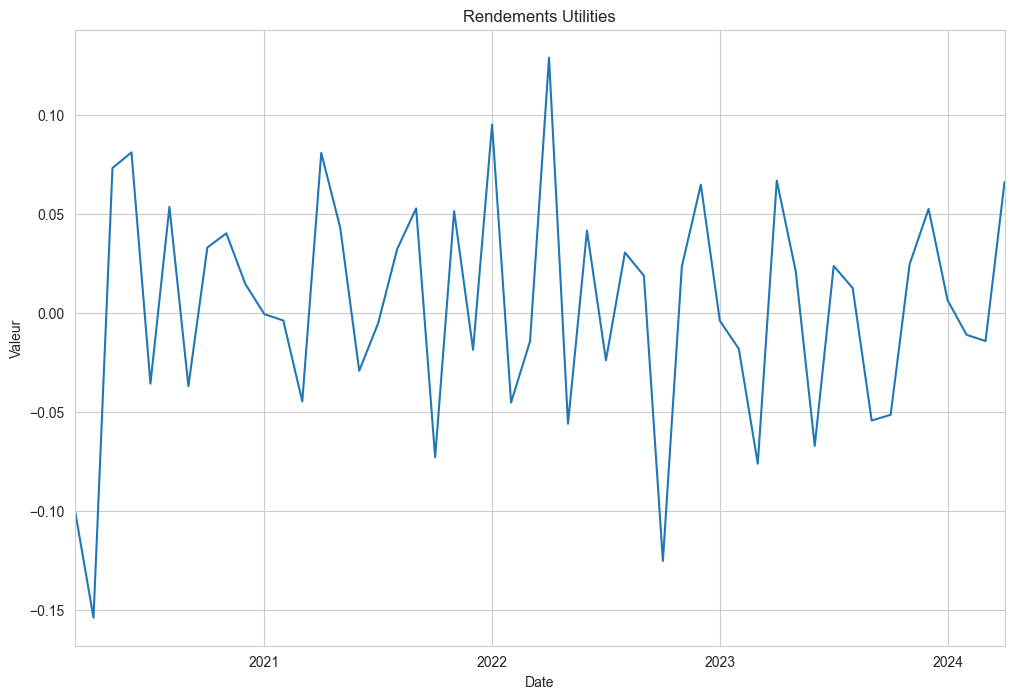

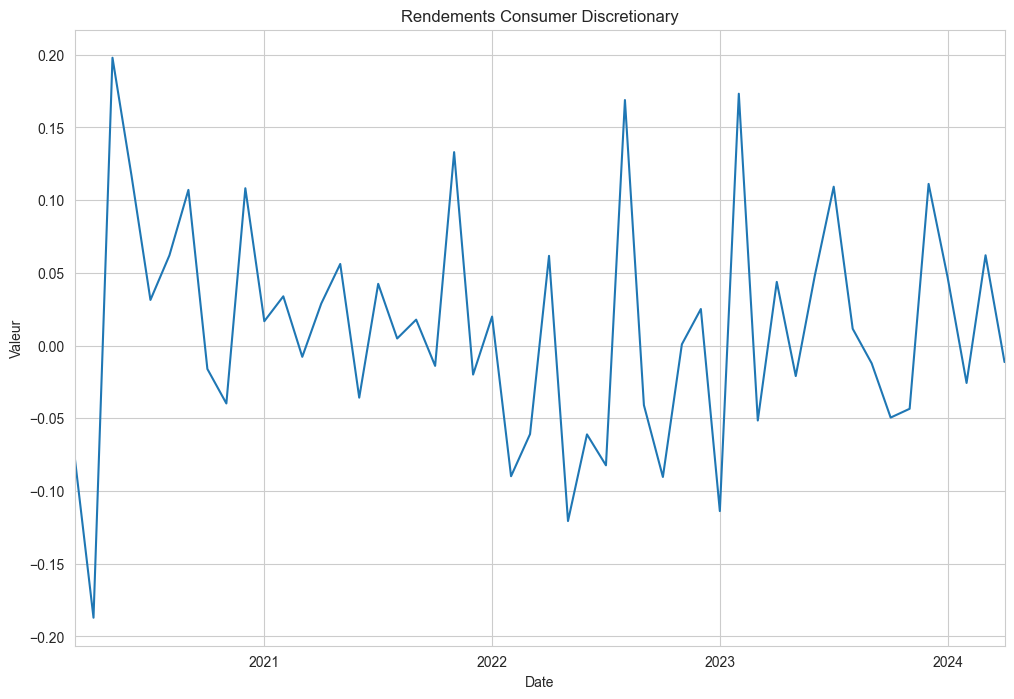

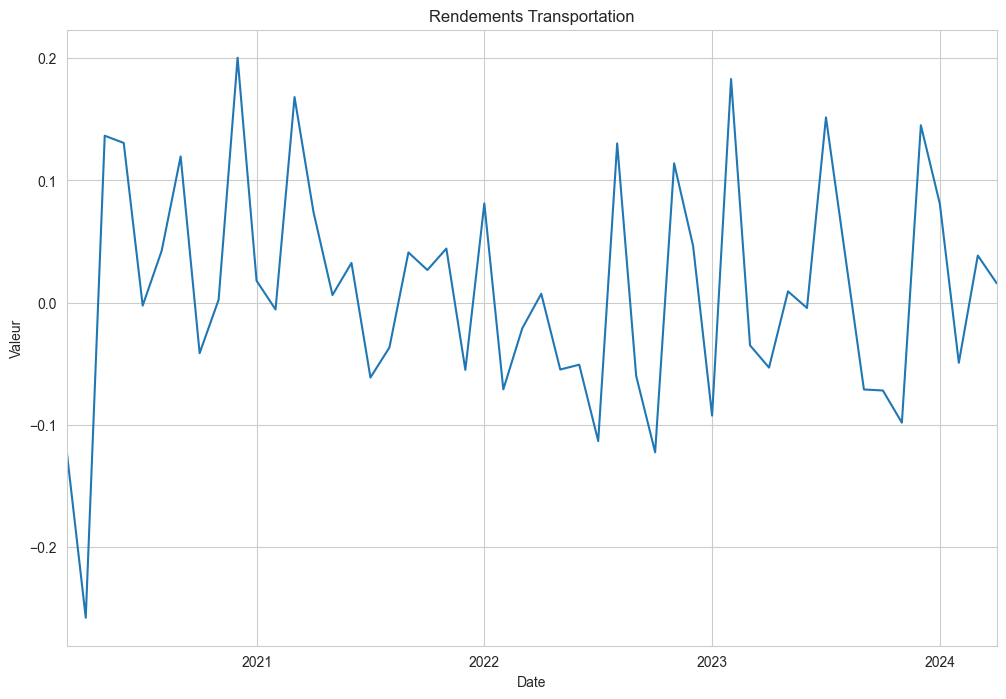

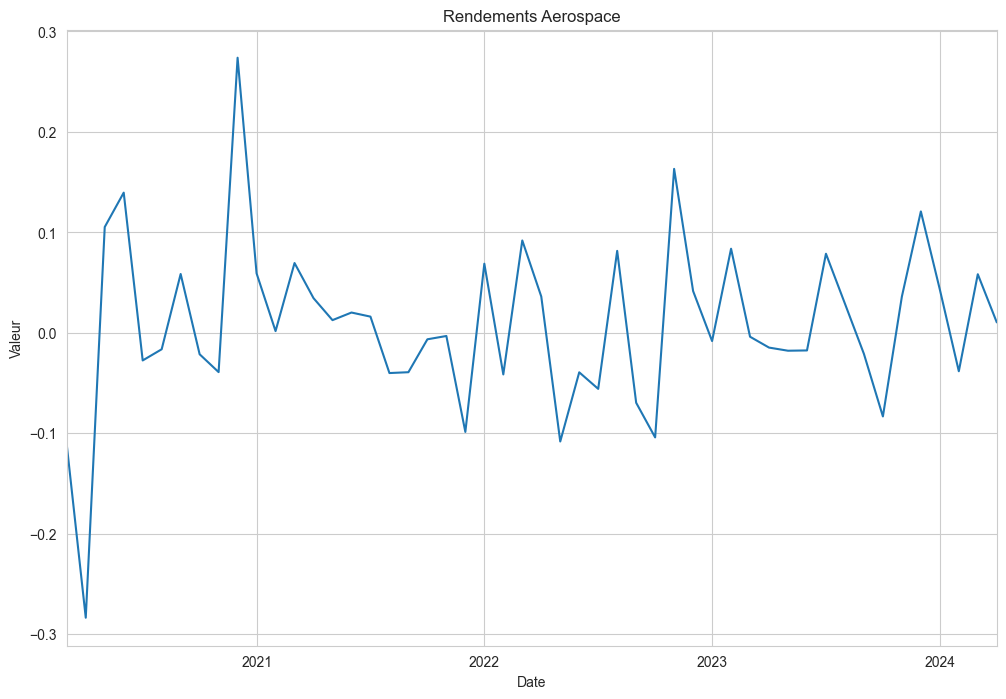

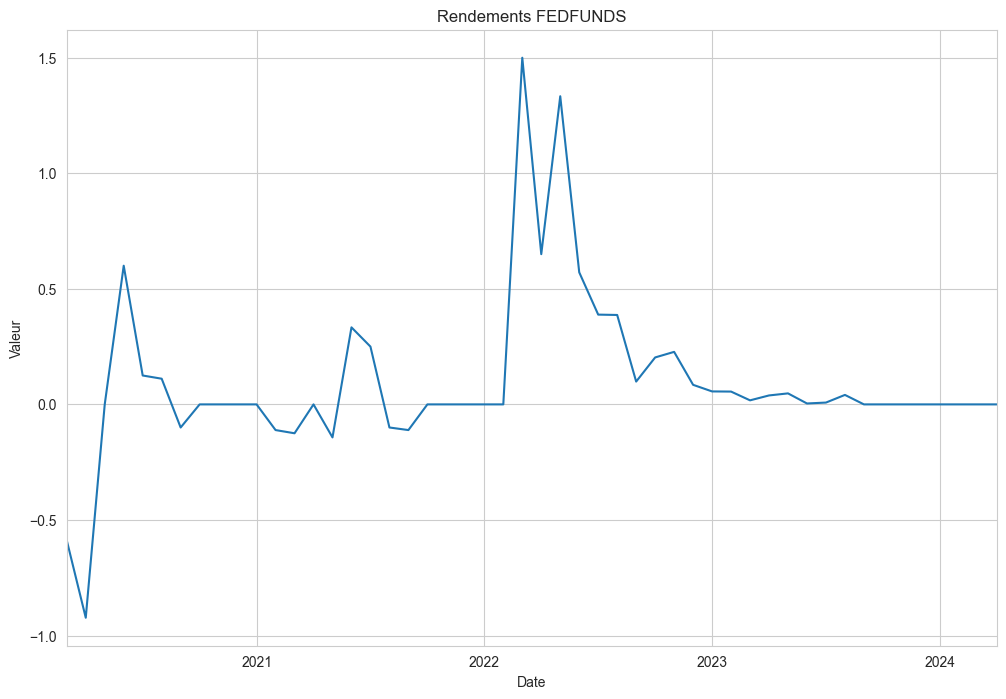

In [7]:
# Grahiques de chaque rendements
for sector in aligned_data.columns:
    aligned_data[sector].plot(figsize=(12, 8))
    plt.xlabel('Date')
    plt.ylabel('Valeur')
    plt.title('Rendements '+sector)
    plt.grid(True)
    
    # Positionner la légende à l'extérieur du graphique
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

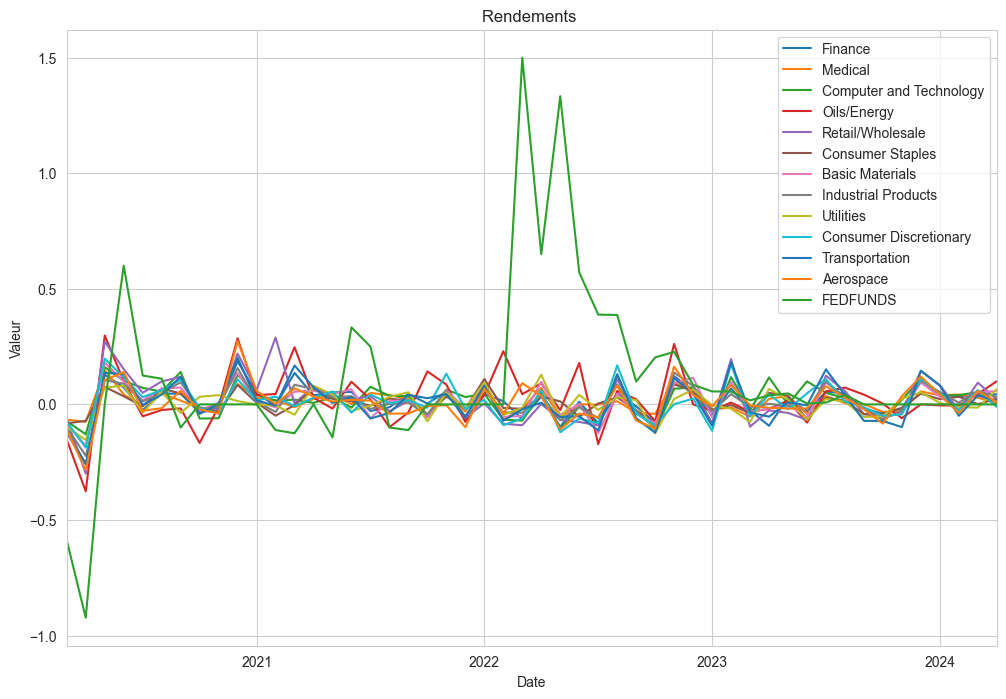

In [8]:
aligned_data.plot(figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Rendements ')
plt.grid(True)
plt.show()

# 1. Tests de causalité de Granger
Ces tests permettent de déterminer si les taux d'intérêt peuvent prédire les rendements des secteurs.

Le test de Granger est une méthode statistique utilisée en économétrie pour déterminer si une série temporelle $ X $ peut être utilisée pour prédire une autre série temporelle $ Y $. Il est couramment utilisé pour examiner la causalité entre deux séries temporelles, en particulier dans le domaine de l'économie et de la finance.

Le test de Granger repose sur l'hypothèse selon laquelle si une série temporelle $ X $ est utile pour prédire une autre série temporelle $ Y $, alors les valeurs passées de $ X $ devraient fournir une information significative pour prédire les valeurs futures de $ Y $ au-delà de ce que les valeurs passées de $ Y $ peuvent fournir seules.

Le test de Granger est généralement effectué en deux étapes :

1. **Modélisation des données** : Les séries temporelles $ X $ et $ Y $ sont modélisées à l'aide d'un modèle de régression multivariée qui inclut les valeurs passées de $ X $ et de $ Y $ en tant que prédicteurs. Par exemple, si nous voulons tester si $ X $ Granger-causalise $ Y $, nous construirons un modèle de régression de la forme :

   $$
   Y_t = \alpha + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{j=1}^{q} \gamma_j X_{t-j} + \epsilon_t
   $$

   où $ \alpha $ est l'ordonnée à l'origine, $ \beta_i $ et $ \gamma_j $ sont les coefficients des valeurs passées de $ Y $ et de $ X $ respectivement, $ p $ et $ q $ sont les ordres du modèle pour les séries $ Y $ et $ X $, et $ \epsilon_t $ est le terme d'erreur.

2. **Test statistique** : Une fois que le modèle est estimé, un test statistique est utilisé pour évaluer si les coefficients associés aux valeurs passées de $ X $ sont statistiquement significatifs. Si les coefficients associés à $ X $ sont statistiquement significatifs, cela suggère que $ X $ Granger-cause $ Y $, c'est-à-dire que l'ajout des valeurs passées de $ X $ améliore significativement la capacité du modèle à prédire $ Y $.

Le test de Granger est souvent utilisé pour explorer les relations de causalité dans les séries temporelles économiques, telles que la relation entre l'inflation et la croissance économique, les taux d'intérêt et l'investissement, etc. Cependant, il est important de noter que la présence d'une corrélation entre deux séries temporelles ne garantit pas nécessairement une relation de causalité. D'autres facteurs et tests doivent également être pris en compte pour établir une relation causale robuste.

In [9]:
# Tests de Granger pour chaque secteur par rapport aux taux de la FED
granger_results = {}
print(sector_data.columns)
for sector in sector_data.columns:
    data_for_test = aligned_data[[sector, 'FEDFUNDS']].dropna()
    granger_result = grangercausalitytests(data_for_test, maxlag=4, verbose=False)
    granger_results[sector] = granger_result
    # Afficher un résumé simple pour chaque secteur
    print(f"Granger Causality results for {sector}:")
    for lag, result in granger_result.items():
        p_value = result[0]['ssr_chi2test'][1]
        print(f"  Lag {lag} p-value: {p_value:.4f}")

Index(['Finance', 'Medical', 'Computer and Technology', 'Oils/Energy',
       'Retail/Wholesale', 'Consumer Staples', 'Basic Materials',
       'Industrial Products', 'Utilities', 'Consumer Discretionary',
       'Transportation', 'Aerospace'],
      dtype='object')
Granger Causality results for Finance:
  Lag 1 p-value: 0.6718
  Lag 2 p-value: 0.0029
  Lag 3 p-value: 0.0052
  Lag 4 p-value: 0.0045
Granger Causality results for Medical:
  Lag 1 p-value: 0.8258
  Lag 2 p-value: 0.0372
  Lag 3 p-value: 0.1125
  Lag 4 p-value: 0.1176
Granger Causality results for Computer and Technology:
  Lag 1 p-value: 0.6346
  Lag 2 p-value: 0.0022
  Lag 3 p-value: 0.0202
  Lag 4 p-value: 0.0161
Granger Causality results for Oils/Energy:
  Lag 1 p-value: 0.7054
  Lag 2 p-value: 0.0242
  Lag 3 p-value: 0.0041
  Lag 4 p-value: 0.0010
Granger Causality results for Retail/Wholesale:
  Lag 1 p-value: 0.3247
  Lag 2 p-value: 0.0080
  Lag 3 p-value: 0.2576
  Lag 4 p-value: 0.7011
Granger Causality results for

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarn

# 2. Analyse de la volatilité avec des modèles GARCH
L'analyse de la volatilité avec des modèles GARCH peut montrer comment la volatilité du secteur réagit aux changements de politique monétaire.


Le modèle GARCH( p , q ) pour une série temporelle $ y_t $ est défini comme suit :

$$ y_t = \mu_t + \epsilon_t $$
$$ \epsilon_t = \sigma_t \cdot z_t $$

Où :
- $ \mu_t $ est la moyenne conditionnelle de la série temporelle à un moment $ t $.
- $ \epsilon_t $ est le résidu à un moment $ t $.
- $ \sigma_t $ est la racine carrée de la variance conditionnelle de $ \epsilon_t $, c'est-à-dire la volatilité conditionnelle à un moment $ t $.
- $ z_t $ est une variable aléatoire standardisée qui suit une distribution normale centrée réduite.

La volatilité conditionnelle $ \sigma_t^2 $ est modélisée comme une combinaison linéaire de ses valeurs passées et des carrés de ses résidus passés, selon la forme générale :

$$ \sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \cdot \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \cdot \sigma_{t-j}^2 $$

Où :
- $ \omega $ est la constante.
- $ \alpha_i $ sont les coefficients des résidus au carré.
- $ \beta_j $ sont les coefficients des valeurs passées de la volatilité.

En résumé, le modèle GARCH est un modèle où la variance conditionnelle est modélisée comme une fonction linéaire de ses propres valeurs passées et des carrés de ses résidus passés. Les paramètres du modèle $ \omega $, $ \alpha $ et $ \beta $ sont estimés à l'aide de méthodes d'estimation statistique telles que la méthode des moindres carrés ordinaires (MCO) ou la méthode du maximum de vraisemblance. Une fois que les paramètres sont estimés, le modèle peut être utilisé pour prédire la volatilité future de la série temporelle.

In [10]:
# Modèles GARCH pour chaque secteur
garch_results = {}
for sector in sector_data.columns:
    returns = aligned_data[sector].dropna()
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fitted = model.fit(disp='off')
    garch_results[sector] = garch_fitted
    print(f"GARCH model results for {sector}:\n{garch_fitted.summary()}\n")

GARCH model results for Finance:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Finance   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                63.9726
Distribution:                  Normal   AIC:                          -119.945
Method:            Maximum Likelihood   BIC:                          -112.297
                                        No. Observations:                   50
Date:                Thu, Jun 20 2024   Df Residuals:                       49
Time:                        23:17:10   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0121 

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

GARCH model results for Transportation:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Transportation   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                49.8907
Distribution:                  Normal   AIC:                          -91.7814
Method:            Maximum Likelihood   BIC:                          -84.1334
                                        No. Observations:                   50
Date:                Thu, Jun 20 2024   Df Residuals:                       49
Time:                        23:17:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             

# 3. Modèles ARIMA pour la prédiction
Utilisation du modèle ARIMA pour prédire l'impact futur des changements des taux sur les indices sectoriels.

Le modèle ARIMA, qui signifie "AutoRegressive Integrated Moving Average", est un modèle statistique utilisé pour modéliser et prévoir les séries temporelles. Il combine les composantes d'autorégression (AR), de moyenne mobile (MA) et d'intégration (I) pour capturer les tendances, les structures de dépendance et les modèles saisonniers des données temporelles.

Voici une explication détaillée de chaque composante :

1. **Composante AR (AutoRegressive)** :
   - L'autorégression fait référence à la régression d'une variable sur ses valeurs passées. Dans un modèle ARIMA, la composante AR représente la relation linéaire entre la variable dépendante et ses propres valeurs retardées. 
   - La notation AR(p) indique qu'il y a p termes AR dans le modèle, ce qui signifie que la valeur actuelle de la série temporelle dépend des p valeurs précédentes.

2. **Composante MA (Moving Average)** :
   - La moyenne mobile est une moyenne des erreurs de prédiction sur une période de temps donnée. Dans un modèle ARIMA, la composante MA représente la dépendance linéaire entre la variable dépendante et les termes d'erreur de ses valeurs retardées.
   - La notation MA(q) indique qu'il y a q termes MA dans le modèle, ce qui signifie que la valeur actuelle de la série temporelle dépend des q erreurs de prédiction précédentes.

3. **Composante I (Integrated)** :
   - L'intégration est utilisée pour rendre la série temporelle stationnaire en différenciant la série à un certain ordre. Cela peut être nécessaire lorsque la série temporelle présente une tendance ou une saisonnalité non stationnaire.
   - La notation I(d) indique qu'il y a eu d différences pour rendre la série temporelle stationnaire.

En combinant ces trois composantes, un modèle ARIMA peut être écrit comme ARIMA(p, d, q), où :
- p est l'ordre de la composante AR.
- d est l'ordre de différenciation.
- q est l'ordre de la composante MA.

Le processus de construction d'un modèle ARIMA implique généralement les étapes suivantes :
1. Identification : Identifier les ordres p, d et q en examinant les graphiques de la série temporelle et les fonctions d'autocorrélation partielle et d'autocorrélation.
2. Estimation : Estimer les paramètres du modèle à l'aide de méthodes telles que la méthode des moindres carrés ordinaires (MCO) ou la méthode du maximum de vraisemblance.
3. Diagnostic : Tester la qualité du modèle en vérifiant si les résidus sont stationnaires et si le modèle est capable de capturer les structures temporelles de la série.
4. Prévision : Utiliser le modèle pour faire des prévisions sur les valeurs futures de la série temporelle.

En résumé, le modèle ARIMA est un outil puissant pour modéliser et prévoir les séries temporelles en capturant les tendances, les structures de dépendance et les modèles saisonniers des données.

1. **Composante AR (AutoRegressive)** :
   - La composante AR d'ordre p est donnée par l'équation :
     $ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \varepsilon_t $
     où $ X_t $ est la série temporelle à l'instant t,
     $ c $ est la constante,
     $ \phi_1, \phi_2, ..., \phi_p $ sont les coefficients AR,
     $ \varepsilon_t $ est le terme d'erreur blanc à l'instant t.

2. **Composante MA (Moving Average)** :
   - La composante MA d'ordre q est donnée par l'équation :
     $$ X_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + ... + \theta_q \varepsilon_{t-q} $$
     où $ \theta_1, \theta_2, ..., \theta_q $ sont les coefficients MA.

3. **Composante I (Integrated)** :
   - La composante intégrée est utilisée pour rendre la série temporelle stationnaire en différenciant la série. Si on différencie la série une fois (d=1), on obtient :
     $$ Y_t = X_t - X_{t-1} $$
   - Si on différencie la série d fois (d=d), on obtient :
     $$ Y_t = (1 - B)^d X_t $$
     où $ B $ est l'opérateur de retard, tel que $ B^d X_t = X_{t-d} $.

Ainsi, un modèle ARIMA(p, d, q) peut être écrit mathématiquement comme suit :
$$ Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + ... + \theta_q \varepsilon_{t-q} + \varepsilon_t $$

Après estimation des coefficients, ce modèle peut être utilisé pour faire des prévisions sur les valeurs futures de la série temporelle $ X_t $.
rie temporelle \( X_t \).

In [11]:
for sector in sector_data.columns:
    # Modélisation ARIMA sur les retours du secteur
    model = ARIMA(aligned_data[sector], order=(1, 1, 1))  # Modèle ARIMA(1,1,1)
    fitted_model = model.fit()
    
    # Prévisions futures
    forecast = fitted_model.forecast(steps=12)  # Prévoir les 12 prochains mois
    print("Prévisions des rendements du secteur "+sector)
    print(forecast)


Prévisions des rendements du secteur Finance
2024-05-01    0.010738
2024-06-01    0.011370
2024-07-01    0.011358
2024-08-01    0.011358
2024-09-01    0.011358
2024-10-01    0.011358
2024-11-01    0.011358
2024-12-01    0.011358
2025-01-01    0.011358
2025-02-01    0.011358
2025-03-01    0.011358
2025-04-01    0.011358
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Medical
2024-05-01    0.011340
2024-06-01    0.010315
2024-07-01    0.010468
2024-08-01    0.010445
2024-09-01    0.010449
2024-10-01    0.010448
2024-11-01    0.010448
2024-12-01    0.010448
2025-01-01    0.010448
2025-02-01    0.010448
2025-03-01    0.010448
2025-04-01    0.010448
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Computer and Technology
2024-05-01    0.021905
2024-06-01    0.019193
2024-07-01    0.019444
2024-08-01    0.019421
2024-09-01    0.019423
2024-10-01    0.019422
2024-11-01    0.019423
2024-12-01    0.019423
2025-01-01    0.019

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions des rendements du secteur Transportation
2024-05-01    0.010617
2024-06-01    0.010797
2024-07-01    0.010791
2024-08-01    0.010791
2024-09-01    0.010791
2024-10-01    0.010791
2024-11-01    0.010791
2024-12-01    0.010791
2025-01-01    0.010791
2025-02-01    0.010791
2025-03-01    0.010791
2025-04-01    0.010791
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Aerospace
2024-05-01    0.008439
2024-06-01    0.008389
2024-07-01    0.008388
2024-08-01    0.008388
2024-09-01    0.008388
2024-10-01    0.008388
2024-11-01    0.008388
2024-12-01    0.008388
2025-01-01    0.008388
2025-02-01    0.008388
2025-03-01    0.008388
2025-04-01    0.008388
Freq: MS, Name: predicted_mean, dtype: float64


## Intégration du modèle VAR
Le modèle VAR est utilisé pour capturer les relations linéaires interdépendantes entre plusieurs séries temporelles. C'est particulièrement utile pour étudier les dynamiques sectorielles en réponse aux changements de politique monétaire.

In [12]:
from statsmodels.tsa.api import VAR

# Préparation des données pour le modèle VAR
# Assurez-vous que toutes les colonnes sont des types float et gérer les valeurs manquantes
aligned_data = aligned_data.dropna().astype(float)

# Création du modèle VAR
var_model = VAR(aligned_data)
var_results = var_model.fit(maxlags=2, ic='aic')  # Déterminer automatiquement l'ordre du lag

# Afficher le résumé du modèle VAR
print(var_results.summary())

# Prévisions avec le modèle VAR
var_forecast = var_results.forecast(aligned_data.values[-var_results.k_ar:], steps=12)  # Prévisions pour les 12 prochains mois

# Convertir les prévisions en DataFrame pour une meilleure lisibilité
var_forecast_df = pd.DataFrame(var_forecast, columns=aligned_data.columns)
print(var_forecast_df)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:17:11
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -71.0915
Nobs:                     48.0000    HQIC:                  -79.6038
Log likelihood:           1500.17    FPE:                1.04286e-36
AIC:                     -84.7746    Det(Omega_mle):     3.15186e-39
--------------------------------------------------------------------
Results for equation Finance
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.038043         0.009330            4.078           0.000
L1.Finance                        -0.720395         0.384664           -1.873           0.061
L1.Med

In [13]:
# Nombre de simulations
num_simulations = 1000
forecast_horizon = 12  # 12 mois

# Stockage des simulations
monte_carlo_simulations = np.zeros((num_simulations, forecast_horizon, len(aligned_data.columns)))

# Effectuer les simulations de Monte Carlo
for n in range(num_simulations):
    for i in range(forecast_horizon):
        if i == 0:
            monte_carlo_simulations[n, i, :] = aligned_data.iloc[-1] + np.random.normal(size=(len(aligned_data.columns),))
        else:
            monte_carlo_simulations[n, i, :] = monte_carlo_simulations[n, i-1, :] + np.random.normal(size=(len(aligned_data.columns),))

# Calculer la moyenne et l'écart type des simulations
mean_forecast = monte_carlo_simulations.mean(axis=0)
std_dev_forecast = monte_carlo_simulations.std(axis=0)

# Affichage des résultats
print("Moyenne des prévisions de Monte Carlo:")
print(mean_forecast)
print("Écart type des prévisions de Monte Carlo:")
print(std_dev_forecast)


Moyenne des prévisions de Monte Carlo:
[[ 0.07128461 -0.03163905  0.0022477   0.05257413  0.05504996  0.04183291
   0.05929737  0.02375247  0.08513266 -0.03624419  0.0128086  -0.00951985
  -0.0061353 ]
 [ 0.08866039 -0.11386141 -0.07144492  0.05486713  0.01788466  0.02627897
   0.10518188  0.03031432  0.11458648 -0.05041726  0.03947201 -0.04622464
  -0.0341401 ]
 [ 0.05171636 -0.11422955 -0.06904249  0.05109476 -0.0448966   0.03114929
   0.16349226  0.00989846  0.12867271 -0.06921176  0.02733852 -0.03205114
  -0.07468767]
 [ 0.01790922 -0.08759904 -0.04523104  0.06727171  0.01842765  0.07208092
   0.15038293 -0.00644396  0.14892753 -0.09962819  0.02970932 -0.01863741
  -0.01027466]
 [ 0.00641704 -0.10871505 -0.05187935  0.06669696  0.05120906  0.08264935
   0.10630865  0.02651701  0.17371094 -0.07624837  0.04010545 -0.02416092
  -0.00519813]
 [ 0.03262531 -0.10026066 -0.0641549   0.07289555  0.07088169  0.08002793
   0.10233561  0.05652403  0.12995986 -0.05337656  0.07895557 -0.0160417

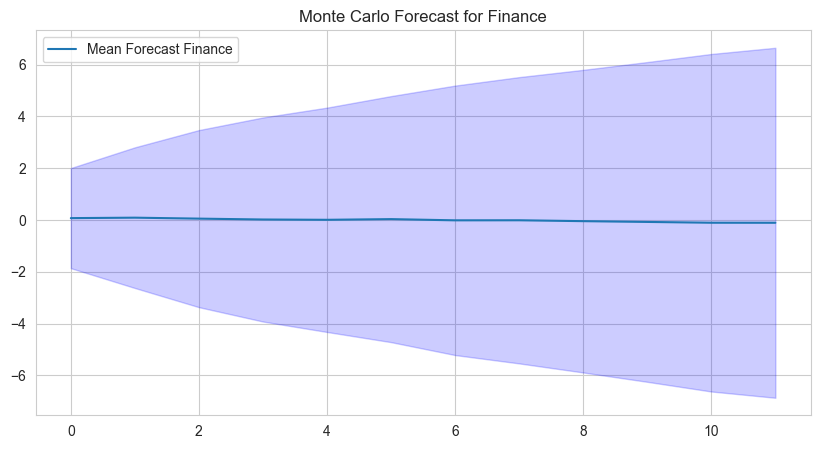

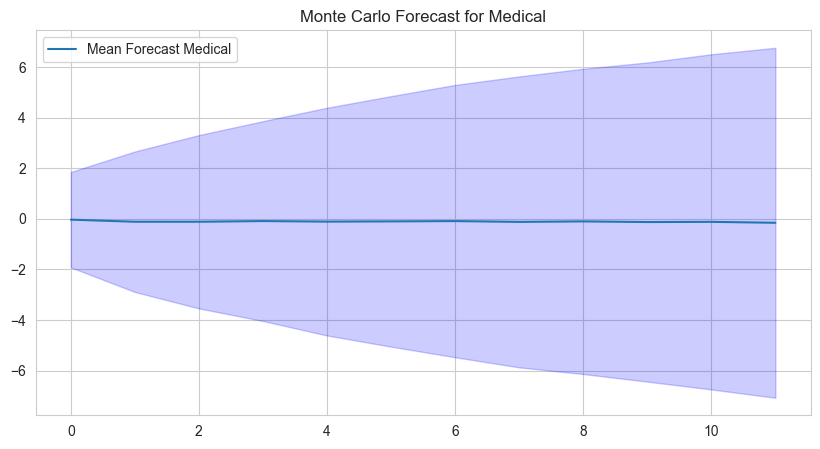

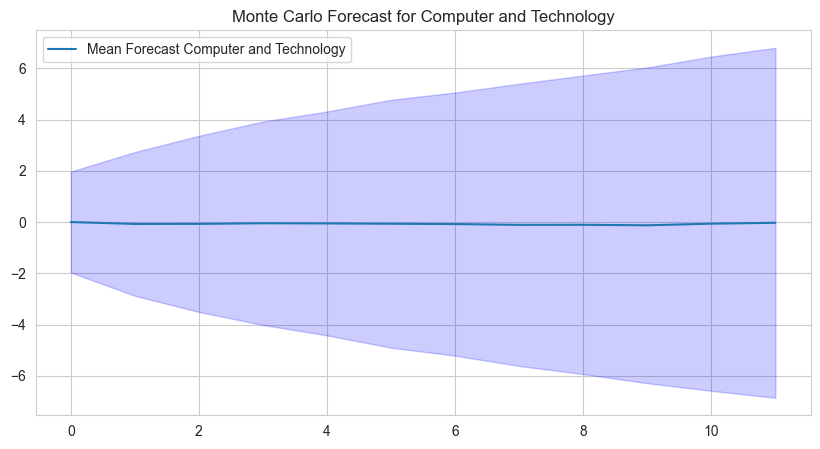

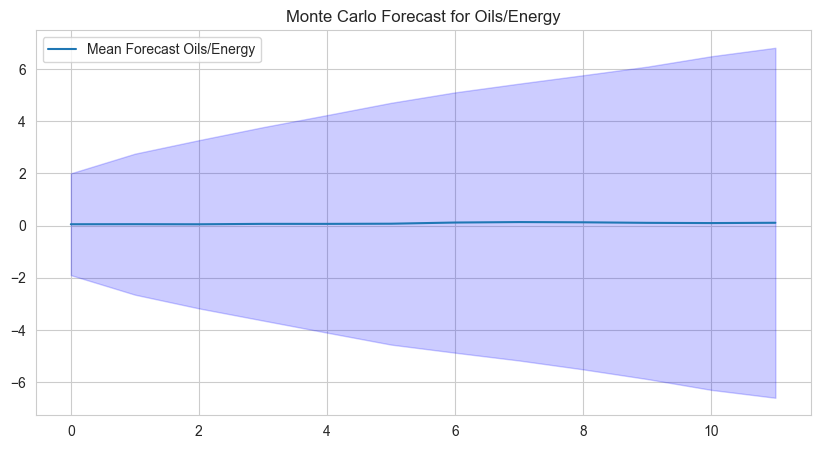

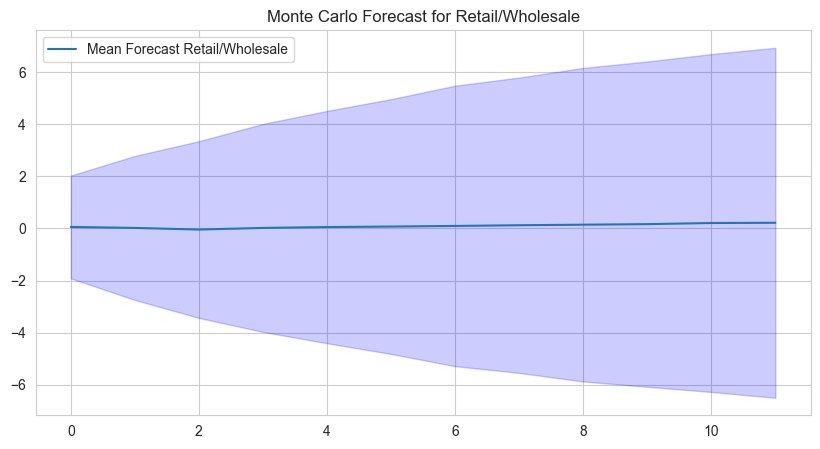

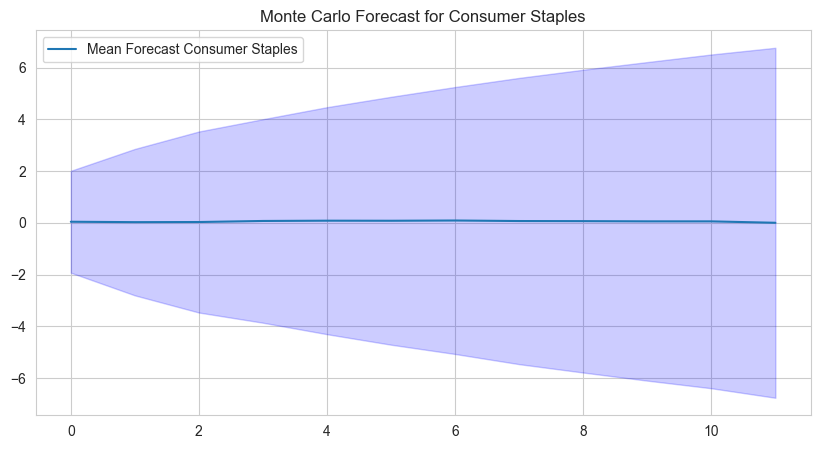

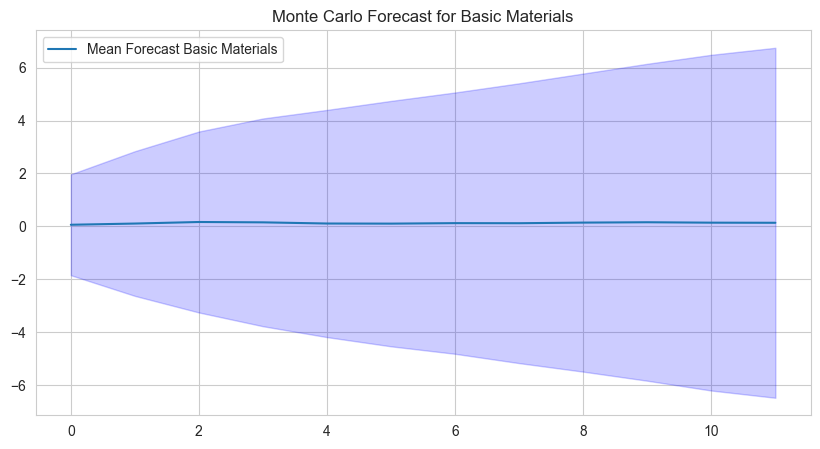

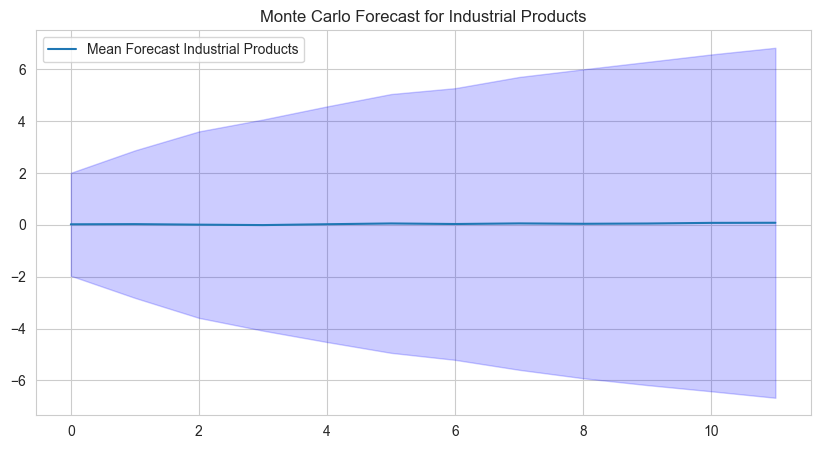

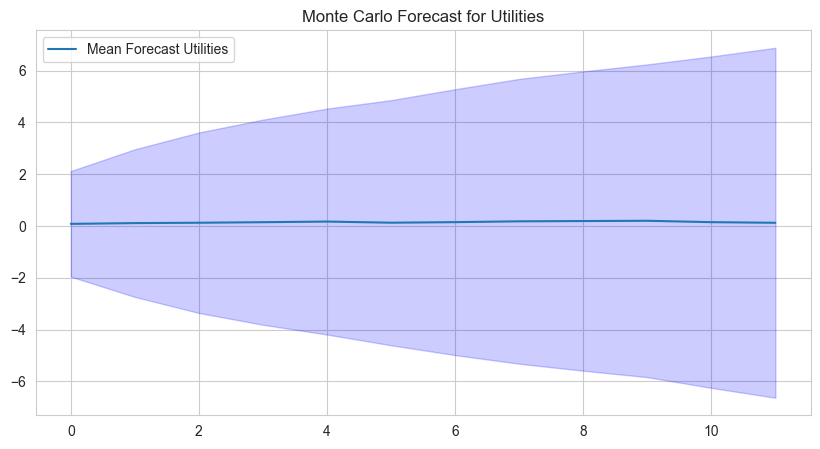

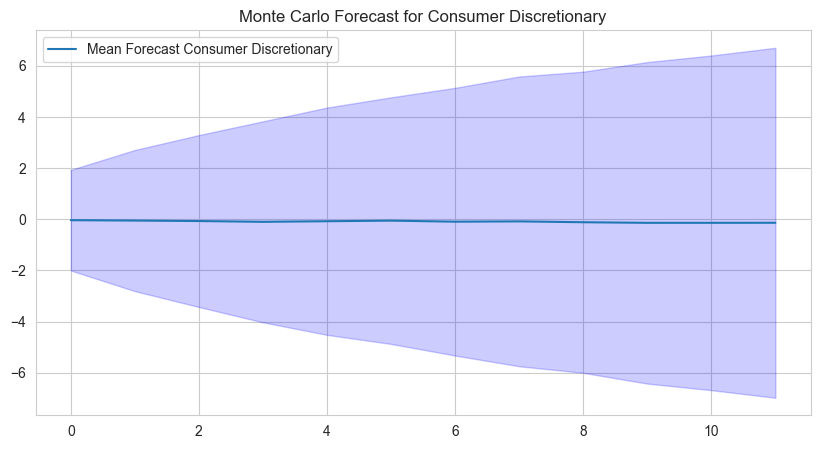

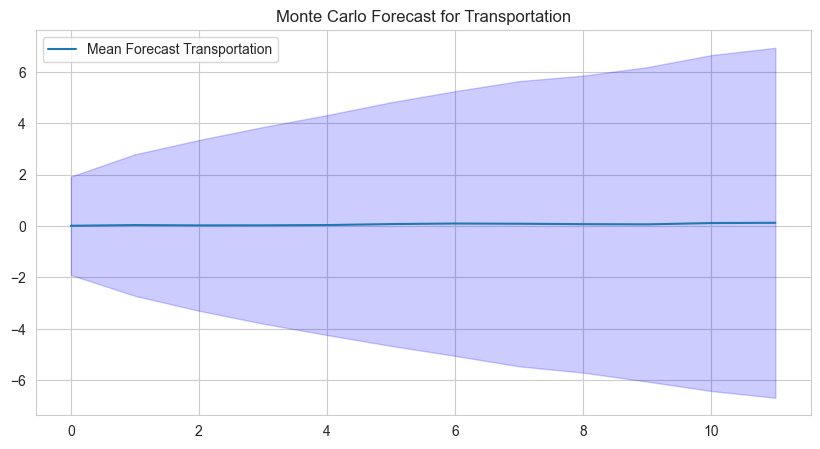

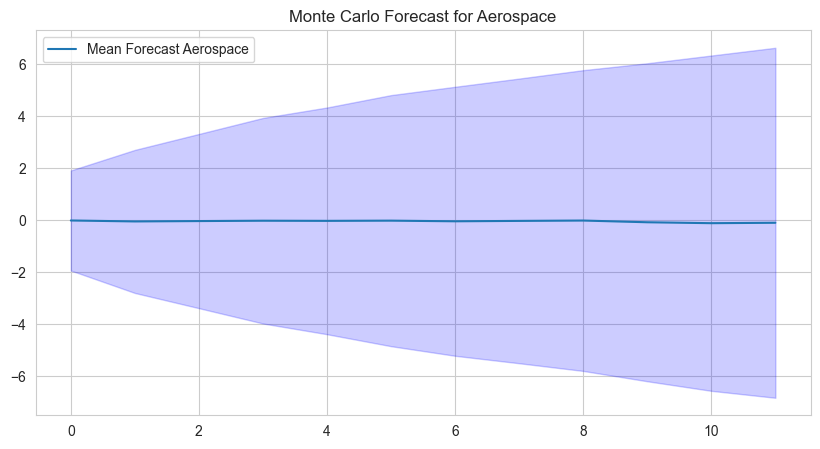

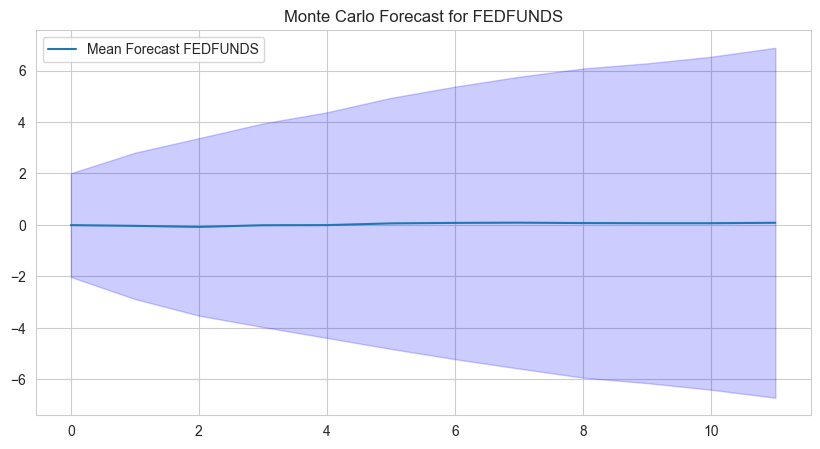

In [14]:

# Plots pour chaque secteur
for idx, sector in enumerate(aligned_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(mean_forecast[:, idx], label=f'Mean Forecast {sector}')
    plt.fill_between(range(forecast_horizon), 
                     mean_forecast[:, idx] - 1.96 * std_dev_forecast[:, idx], 
                     mean_forecast[:, idx] + 1.96 * std_dev_forecast[:, idx], color='b', alpha=0.2)
    plt.title(f'Monte Carlo Forecast for {sector}')
    plt.legend()
    plt.show()
